# Notebook: Segmentation for Biosensor Data (Fixed/Sliding vs Dynamic)

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = Path("../data/biosensor_preprocessed_all.csv")
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

# Detect key columns (adjust manually if needed)
id_col = "Athlete_ID" if "Athlete_ID" in df.columns else next(c for c in df.columns if "athlete" in c.lower() or "subject" in c.lower())
ts_col = next(c for c in df.columns if "time" in c.lower() or "timestamp" in c.lower())
label_col = next(c for c in df.columns if c.lower() in ("activity", "label", "event_label", "target"))

# Force timestamp parse (important)
df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
df = df.dropna(subset=[ts_col]).sort_values([id_col, ts_col]).reset_index(drop=True)

print("Loaded:", df.shape, "| Athletes:", df[id_col].nunique())
print("Columns:", {"id_col": id_col, "ts_col": ts_col, "label_col": label_col})
df.head()

Loaded: (1500, 19) | Athletes: 5
Columns: {'id_col': 'Athlete_ID', 'ts_col': 'Timestamp', 'label_col': 'Event_Label'}


,Athlete_ID,Timestamp,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Heart_Rate,Event_Label,Acc_X_filt,Acc_Y_filt,Acc_Z_filt,Gyro_X_filt,Gyro_Y_filt,Gyro_Z_filt,Heart_Rate_clean,AccMag,GyroMag
0,A001,2025-05-11 12:14:53.417747,-2.598157,2.205079,-0.649084,-48.457966,15.407057,164.550534,166.0,Accel,-2.597449,2.204663,-0.648484,-48.411588,15.296617,164.607955,165.891856,3.468114,172.259824
1,A001,2025-05-11 12:14:53.517747,-2.862471,2.173831,-2.054184,5.137738,34.974254,-15.283653,159.0,Jump_Takeoff,-1.737485,1.935216,-0.311066,-81.804516,-19.217660,90.374208,156.202222,2.619289,123.405003
2,A001,2025-05-11 12:14:53.617747,-1.045441,2.755975,2.696018,-175.960480,-107.481553,177.757215,120.0,Stop,-0.209785,1.624882,0.040147,-80.923644,0.661835,28.506813,147.099820,1.638860,85.800423
3,A001,2025-05-11 12:14:53.717747,2.931939,0.005220,-1.835028,-8.255970,131.909447,-172.149554,119.0,Sprint_Mid,1.388217,1.514679,0.397453,-44.107409,68.796723,-17.468701,139.051530,2.092694,83.567985
4,A001,2025-05-11 12:14:53.817747,2.517730,1.217080,1.611578,-44.266911,147.303725,104.186863,121.0,Start_Run,1.922455,1.627218,0.682295,-8.240077,128.410295,-47.572022,132.429719,2.609443,137.186734


In [11]:
def estimate_fs(g):
    t = g[ts_col].to_numpy(dtype="datetime64[ns]")
    if len(t) < 2:
        return np.nan
    dt_ns = np.diff(t).astype("timedelta64[ns]").astype(np.int64)
    dt_ns = dt_ns[dt_ns > 0]
    if len(dt_ns) == 0:
        return np.nan
    return 1.0 / (np.median(dt_ns) / 1e9)

fs_per_athlete = df.groupby(id_col).apply(estimate_fs)
FS = float(np.nanmedian(fs_per_athlete))

print("Estimated Hz per athlete:\n", fs_per_athlete)
print("Using FS =", FS)

Estimated Hz per athlete:
 Athlete_ID
A001    10.0
A002    10.0
A003    10.0
A004    10.0
A005    10.0
dtype: float64
Using FS = 10.0


C:\Users\azure\AppData\Local\Temp\ipykernel_54104\1571865839.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fs_per_athlete = df.groupby(id_col).apply(estimate_fs)


In [12]:
def sliding_windows_time(g, window_sec, step_sec):
    """
    Returns list of (start_row, end_row) row-index pairs for one athlete,
    based on timestamp offsets in seconds.
    """
    g = g.sort_values(ts_col).reset_index(drop=True)
    t = g[ts_col].to_numpy(dtype="datetime64[ns]")
    t0 = t[0]
    t_sec = (t - t0).astype("timedelta64[ns]").astype(np.int64) / 1e9

    windows = []
    start_t = float(t_sec.min())
    end_t = float(t_sec.max())

    cur = start_t
    while cur + window_sec <= end_t:
        mask = (t_sec >= cur) & (t_sec < cur + window_sec)
        idx = np.where(mask)[0]
        if len(idx) > 0:
            windows.append((int(idx[0]), int(idx[-1])))
        cur += step_sec

    return windows

In [13]:
# >= 10 window sizes
WINDOW_SIZES = [0.5, 0.75, 1.0, 1.25, 1.5,
                1.75, 2.0, 2.5, 3.0, 4.0, 5.0]

STEP_RATIO = 0.5  # 50% overlap

# Choose which signal to compute variance on
# Prefer magnitude columns if present
sig_candidates = [c for c in df.columns if c.lower() in ("accmag", "gyromag")]
if len(sig_candidates) > 0:
    eval_signal = sig_candidates[0]
else:
    # fallback to any accel filtered/raw column
    accel_like = [c for c in df.columns if "acc" in c.lower()]
    eval_signal = accel_like[0] if accel_like else None

print("Evaluation signal:", eval_signal)

Evaluation signal: AccMag


In [14]:
results = []

for W in WINDOW_SIZES:
    STEP = W * STEP_RATIO
    n_windows = 0
    purities = []
    variances = []

    for pid, g in df.groupby(id_col):
        g = g.sort_values(ts_col).reset_index(drop=True)
        win_idx = sliding_windows_time(g, W, STEP)

        for s, e in win_idx:
            w = g.iloc[s:e+1]

            # label purity = fraction of majority label
            vc = w[label_col].value_counts(normalize=True)
            purity = float(vc.iloc[0]) if len(vc) else np.nan
            purities.append(purity)

            # stability proxy = variance of one representative signal
            if eval_signal is not None and eval_signal in w.columns:
                variances.append(float(w[eval_signal].var()))
            else:
                variances.append(np.nan)

        n_windows += len(win_idx)

    results.append({
        "window_sec": W,
        "step_sec": STEP,
        "num_windows": n_windows,
        "mean_label_purity": float(np.nanmean(purities)) if len(purities) else np.nan,
        "mean_imu_variance": float(np.nanmean(variances)) if np.any(~np.isnan(variances)) else np.nan,
    })

results_df = pd.DataFrame(results)
results_df

,window_sec,step_sec,num_windows,mean_label_purity,mean_imu_variance
0,0.50,0.250,590,0.433220,0.312495
1,0.75,0.375,390,0.371978,0.352389
2,1.00,0.500,290,0.343793,0.365554
3,1.25,0.625,230,0.324443,0.371929
4,1.50,0.750,190,0.305263,0.382728
5,1.75,0.875,165,0.293741,0.392483
6,2.00,1.000,140,0.287143,0.387822
7,2.50,1.250,110,0.271273,0.396631
8,3.00,1.500,90,0.262222,0.403012
9,4.00,2.000,65,0.254231,0.398946


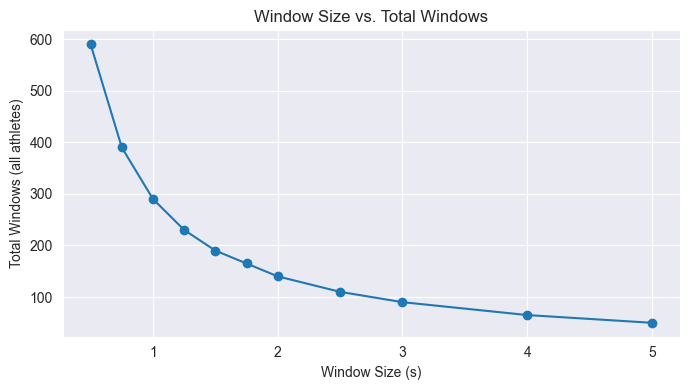

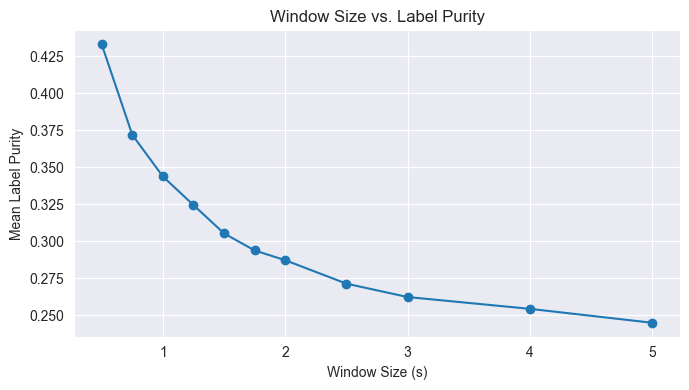

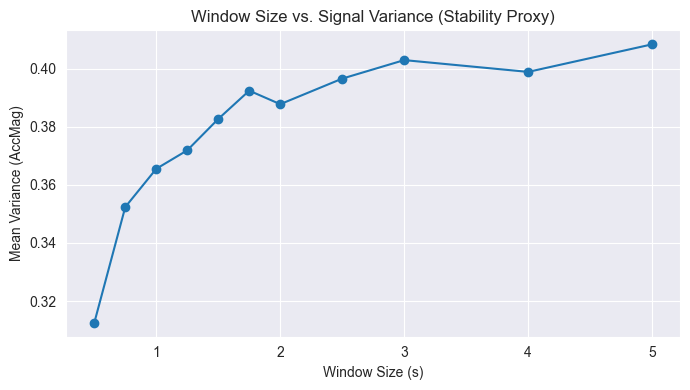

In [15]:
# Plot: number of windows
plt.figure(figsize=(7,4))
plt.plot(results_df["window_sec"], results_df["num_windows"], marker="o")
plt.xlabel("Window Size (s)")
plt.ylabel("Total Windows (all athletes)")
plt.title("Window Size vs. Total Windows")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: label purity
plt.figure(figsize=(7,4))
plt.plot(results_df["window_sec"], results_df["mean_label_purity"], marker="o")
plt.xlabel("Window Size (s)")
plt.ylabel("Mean Label Purity")
plt.title("Window Size vs. Label Purity")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: variance proxy
plt.figure(figsize=(7,4))
plt.plot(results_df["window_sec"], results_df["mean_imu_variance"], marker="o")
plt.xlabel("Window Size (s)")
plt.ylabel(f"Mean Variance ({eval_signal})" if eval_signal else "Mean Variance")
plt.title("Window Size vs. Signal Variance (Stability Proxy)")
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the trade-off between sample availability, label purity, and signal stability, window sizes between 1.25 and 1.5 seconds provide the best balance. Smaller windows produce many samples but are less stable, while larger windows reduce sample count and mix multiple activities. We therefore select a 1.5-second sliding window with 50% overlap for downstream feature extraction and modeling.

In [16]:
FINAL_WINDOW_SEC = 1.5
STEP_RATIO = 0.5
FINAL_STEP_SEC = FINAL_WINDOW_SEC * STEP_RATIO

print(f"Final choice: window={FINAL_WINDOW_SEC}s, step={FINAL_STEP_SEC}s ({int(STEP_RATIO*100)}% overlap)")

Final choice: window=1.5s, step=0.75s (50% overlap)


In [17]:
def sliding_windows_time(g, window_sec, step_sec):
    g = g.sort_values(ts_col).reset_index(drop=True)
    t = g[ts_col].to_numpy(dtype="datetime64[ns]")
    t0 = t[0]
    t_sec = (t - t0).astype("timedelta64[ns]").astype(np.int64) / 1e9

    windows = []
    start_t = float(t_sec.min())
    end_t = float(t_sec.max())

    cur = start_t
    while cur + window_sec <= end_t:
        mask = (t_sec >= cur) & (t_sec < cur + window_sec)
        idx = np.where(mask)[0]
        if len(idx) > 0:
            windows.append((int(idx[0]), int(idx[-1])))
        cur += step_sec

    return windows

final_windows = []

for pid, g in df.groupby(id_col):
    g = g.sort_values(ts_col).reset_index(drop=True)
    win_idx = sliding_windows_time(g, FINAL_WINDOW_SEC, FINAL_STEP_SEC)

    for i, (s, e) in enumerate(win_idx):
        w = g.iloc[s:e+1].copy()

        # majority label for this window
        label = w[label_col].mode().iloc[0]

        final_windows.append({
            "athlete_id": pid,
            "window_local_idx": i,
            "start_ts": w[ts_col].iloc[0],
            "end_ts": w[ts_col].iloc[-1],
            "label": label,
            "data": w
        })

print("Final windows generated:", len(final_windows))

Final windows generated: 190


In [18]:
final_meta = pd.DataFrame([{
    "athlete_id": w["athlete_id"],
    "label": w["label"],
    "start_ts": w["start_ts"],
    "end_ts": w["end_ts"],
} for w in final_windows])

print("Windows per athlete:")
print(final_meta["athlete_id"].value_counts().sort_index())

print("\nWindow-level label distribution:")
print(final_meta["label"].value_counts())

Windows per athlete:
athlete_id
A001    38
A002    38
A003    38
A004    38
A005    38
Name: count, dtype: int64

Window-level label distribution:
label
Jump_Takeoff    42
Start_Run       38
Accel           36
Stop            27
Sprint_Mid      24
Landing         23
Name: count, dtype: int64


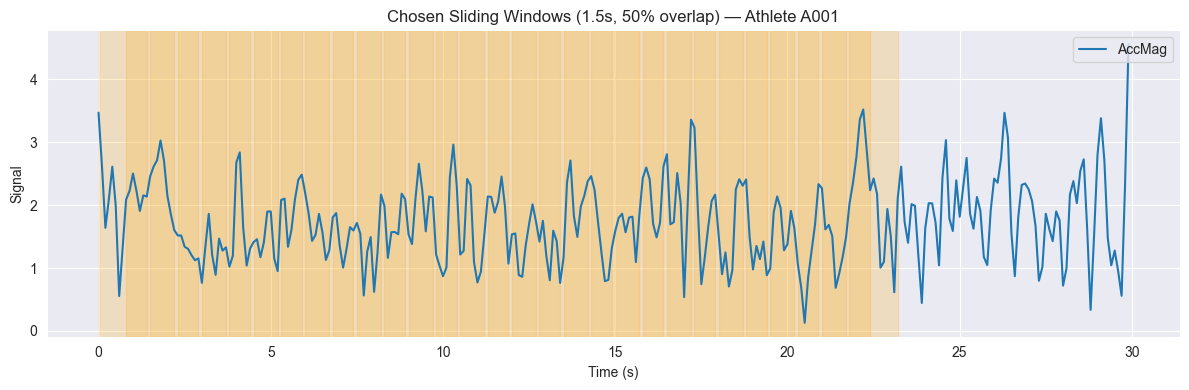

In [19]:
pid0 = df[id_col].iloc[0]
g = df[df[id_col] == pid0].sort_values(ts_col).reset_index(drop=True)
t = (g[ts_col] - g[ts_col].iloc[0]).dt.total_seconds()

plot_sig = "AccMag" if "AccMag" in g.columns else next((c for c in g.columns if "acc" in c.lower()), None)

plt.figure(figsize=(12,4))
if plot_sig:
    plt.plot(t, g[plot_sig], label=plot_sig)

win_idx = sliding_windows_time(g, FINAL_WINDOW_SEC, FINAL_STEP_SEC)
for s, e in win_idx[:30]:  # first ~30 windows to avoid dark overlay
    plt.axvspan(t.iloc[s], t.iloc[e], color="orange", alpha=0.2)

plt.title(f"Chosen Sliding Windows ({FINAL_WINDOW_SEC}s, {int(STEP_RATIO*100)}% overlap) — Athlete {pid0}")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
from pathlib import Path

OUT_DIR = Path("../data/windows_multi_final")
OUT_DIR.mkdir(parents=True, exist_ok=True)

index_rows = []

for w in final_windows:
    win_id = f"{w['athlete_id']}_W{w['window_local_idx']:04d}_WS{str(FINAL_WINDOW_SEC).replace('.','p')}"
    file_path = OUT_DIR / f"{win_id}.csv"

    w["data"].to_csv(file_path, index=False)

    index_rows.append({
        "window_id": win_id,
        "athlete_id": w["athlete_id"],
        "start_ts": w["start_ts"],
        "end_ts": w["end_ts"],
        "label": w["label"],
        "window_sec": FINAL_WINDOW_SEC,
        "step_sec": FINAL_STEP_SEC,
        "file": str(file_path)
    })

index_df = pd.DataFrame(index_rows)
index_path = OUT_DIR / "windows_index.csv"
index_df.to_csv(index_path, index=False)

print("✅ Saved final windows to:", OUT_DIR)
print("✅ Index saved to:", index_path)
index_df.head()

✅ Saved final windows to: ..\data\windows_multi_final
✅ Index saved to: ..\data\windows_multi_final\windows_index.csv


,window_id,athlete_id,start_ts,end_ts,label,window_sec,step_sec,file
0,A001_W0000_WS1p5,A001,2025-05-11 12:14:53.417747,2025-05-11 12:14:54.817747,Landing,1.5,0.75,..\data\windows_multi_final\A001_W0000_WS1p5.csv
1,A001_W0001_WS1p5,A001,2025-05-11 12:14:54.217747,2025-05-11 12:14:55.617747,Accel,1.5,0.75,..\data\windows_multi_final\A001_W0001_WS1p5.csv
2,A001_W0002_WS1p5,A001,2025-05-11 12:14:54.917747,2025-05-11 12:14:56.317747,Accel,1.5,0.75,..\data\windows_multi_final\A001_W0002_WS1p5.csv
3,A001_W0003_WS1p5,A001,2025-05-11 12:14:55.717747,2025-05-11 12:14:57.117747,Start_Run,1.5,0.75,..\data\windows_multi_final\A001_W0003_WS1p5.csv
4,A001_W0004_WS1p5,A001,2025-05-11 12:14:56.417747,2025-05-11 12:14:57.817747,Stop,1.5,0.75,..\data\windows_multi_final\A001_W0004_WS1p5.csv
